# Application of Population Predictive Checks (POP-PC) to Bayesian Models 

Due to recent developments in approximate posterior inference, Bayesian models have become much more easier to build. Therefore the assessment of the models are becoming a bigger concern. The paper Population Predictive Checks [Ranganath, Blei 2019] introduces an assessment framework called the POP-PC for Bayesian models, and show examples of applying it to the Dirichlet Process, Bayesian Linear Regression, and Latent Dirichlet Allocation. Since they have not proven the strength of POP-PCs for other Bayesian models such as Matrix Factorization (MF) and Gaussian Mixture Models (GMM), we have decided to test the POP-PC model assessment framework on these two models.

### Posterior Predictive Checks

PPCs are a powerful model-checking procedure that performs the following: simulate replicated data from the posterior predictive distribution, compute a discrepancy that measures "relevance", and compare the distance between the discrepancy of observed and replicated data.

More formally, A PPC is defined by:
\begin{equation}
    PPC(x^{obs}; g, d) = E[g(d(x^{rep}, \theta), d(x^{obs}, \theta)) | x^{obs}]
\end{equation}
Where $d(y, \theta)$ is the discrepancy function and $g(\cdot, \cdot)$ is a distance function. [Ranganath & Blei, 2019]

### Population Predictive Checks

__Issue__: PPCs tend to overfit due to "double dipping" the data, i.e. we compute the discrepancy of replicated data based on latent variables we obtained from the observed data.

__Solution__: Population Predictive Checks [Ranganath & Blei, 2019]. Use Bootstrap or Cross-validation to obtain $x^{new}$ to model the true distribution F. This follows the intuition: “If my model is good (in a relevant way) then data drawn from the posterior predictive distribution of a group will look like data from the true population of that group.”

A POP-PC is defined by
\begin{equation}
    POP-PC(x^{obs}, F; g, d) = E[g(d(x^{rep}, \theta), d(x^{new}, \theta)) | x^{obs}, F]
\end{equation}

## Discrepancies

In PPCs (Posterior Predictive Checks, another model assessment framework) and POP-PCs, the predicted probability distribution is compared with a target distribution. Specifically, the target distribution for PPCs is the observed data (train data) and for POP-PCs it is the nonobserved data (test data). The comparison is conducted with the help of discrepancies, which are functions of the data that measures something that you want to see in the distributions (ex. mean, median, range, log-likelihood, etc.).

## Data

In our project, we use the MovieLens Dataset, which consists of ratings and metadata of movies. Specifically, we use the ratings_small.csv, which is a subset of the entire dataset. (subset consists of 100,000 ratings from 700 users on 9,000 movies)

### Import Relevant Packages

In [49]:
%matplotlib inline

import os
import time
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pickle
import warnings

import util_pmf as util_pmf
import util_gmm as util_gmm

from collections import defaultdict
from numpy.linalg import inv
from pyro import poutine
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer import Predictive

warnings.filterwarnings("ignore")
assert pyro.__version__.startswith('0.5.1')

First, we are going to start with PMF, then GMM. (Note that we will use POP-PC and PPC at the very end of each model/section)

## Matrix Factorization (MF) using the MovieLens Dataset

In this section, we will use 3 different types of MF to predict the ratings of each users. MF is a technique to represent a given matrix with the product of two matrices. In our setting, one of matrices will represent users$\times$latent factors (matrix $u$), the other matrix will represent movies$\times$latent factors (matrix  $v$), and the product of those two matrices will represent the ratings of each movie given by the users. 

Note that we will only use movies that have more than 4 ratings.

### Data Preprocessing and Preparation

In [3]:
# For the following functions, set checker=0 when it is your
# first time running this preprocessing (creates files)
# Otherwise, set checker to any number when you
# already have those files
ratings_df = util_pmf.data_prepare_load(checker=1)
train_ratings, test_ratings = util_pmf.train_test_split(ratings_df, checker=1)
train_ratings = util_pmf.reindex_train(train_ratings, checker=1)
zero_imputated_ratings = util_pmf.zero_imputation(
    ratings_df, train_ratings, checker=1)
is_observed = (zero_imputated_ratings != 0)

### Distribution of Ratings (with more than 4 reviews)

#### Distribution of All Ratings

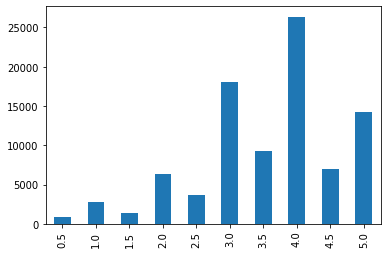

In [4]:
Jayratings_df['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
).plot(kind='bar')

#### Distribution of Train Data Ratings

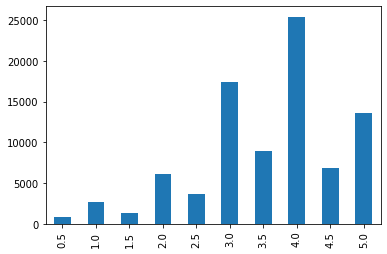

In [5]:
train_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
).plot(kind='bar')

#### Distribution of Test Data Ratings

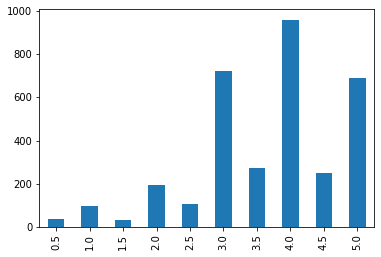

In [6]:
test_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
).plot(kind='bar')

### Model: Probabilistic Matrix Factorization (PMF)

Now we implement the Probabilistic Matrix Factorization (PMF) model, which is the simplest "probabilistic" MF model. 

Given a rating matrix $R$,  user matrix $U$, movie matrix $V$, and variance $\sigma$, the likelihood of PMF is:

\begin{equation}
    p(R_{ij} | U_i, V_j, \mu, \sigma^2) = N(R_{ij}| U_i, V_j, \mu, \sigma^2)
\end{equation}

where the user and feature vectors are given Gaussian priors:
\begin{equation}
    p(U|\mu_U, \sigma_U^2) = \prod_{i=1}^{N_U}N(U_i|\mu_U,\sigma_U^2I) \\
    p(V|\mu_V, \sigma_V^2) = \prod_{j=1}^{N_V}N(V_j|\mu_V,\sigma_V^2I)
\end{equation}

We set $\mu_U=\mu_V=0$ and $\sigma_U=\sigma_V=1$ here for simplicity.

For $k$ (represents latent factors of user and feature vectors), we chose $k=10$ for all MF models in this section.

In [7]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        u = pyro.sample('u', dist.MultivariateNormal(
            torch.zeros(k), 1*torch.eye(k)))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        v = pyro.sample('v', dist.MultivariateNormal(
            torch.zeros(k), 1*torch.eye(k)))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Normal(torch.mm(u, v.T), 1), obs=data)

### Inference

We use NUTS MCMC to approximate the posterior distribution of $p(u,v|R,\lambda, \mu, \sigma)$. Then we take the average of the sampled 100 $u^Tv$s as the predicted ratings of the movies given by users. Note that this is how inference is done for the rest of the MF section.

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

In [ ]:
# Run this when you do not have 'pmf_posterior_samples.pickle'
"""
with open('../data/pmf_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
rounded_estimate_ratings = util_pmf.calc_average_ratings(
                        posterior_samples['u'], posterior_samples['v'])
with open('../data/pmf_rounded_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(rounded_estimate_ratings, handle,
    protocol=pickle.HIGHEST_PROTOCOL)
"""

In [8]:
with open('../data/pmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

### Criticism

We compare the distribution of estimated ratings using PMF and the distribution of the train and test data. Note that we will conduct POP-PC and PPC at the very end of this section.

#### Distribution of Estimated Ratings using PMF

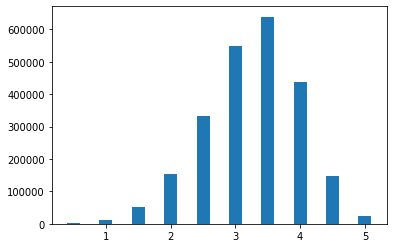

In [9]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Ratings Train Data

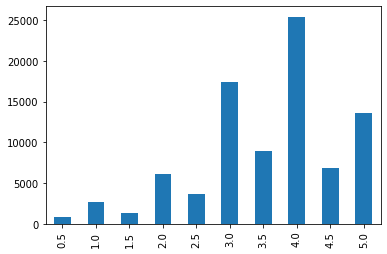

In [10]:
train_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]).plot(kind='bar')

#### Distribution of Ratings Test Data

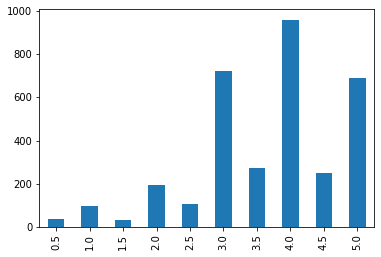

In [11]:
test_ratings['rating'].value_counts().reindex(
    [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]).plot(kind='bar')

- Compared to the train data, the entire predicted distribution is shifted towards the left side, where the mean of the training data is located. 
- Compared to the test data, the predictions are strongly underestimating movies with high rated movies.

To summarize, the PMF model can be thought to be overfitting by capturing the mean of the train data too strongly, preventing balanced predictions. The MAP objective may be causing these concentrated predictions.

### Model: Bayesian Probabilistic Matrix Factorization (BPMF)

In PMF, each user and movie had the same Normal distribution prior with constant mean and variance. In BMF, a prior distribution is set on the mean and variance of the Normal distributions of each user and each movie. This allows more flexibility in representing the different preferences of users and rating trends of movies using the decomposed matrices, producing more balanced predictions. 

\begin{equation}
    p(R_{ij} | U_i, V_j, \mu, \sigma^2) = N(R_{ij}| U_i, V_j, \mu, \sigma^2)
\end{equation}

where

\begin{equation}
    p(U_i|\mu_{U_i}, \sigma_{U_i}^2) = N(U_i|\mu_{U_i},\sigma_{U_i}^2I) \\
    p(V_j|\mu_{V_j}, \sigma_{V_j}^2) =N(V_j|\mu_{V_j},\sigma_{V_j}^2I) \\
    p(\mu_{U_i}) = N(0,1) \\
    p(\sigma^2_{U_i}) = InvGam(1,1) \\
    p(\mu_{V_j}) = N(0,1) \\
    p(\sigma^2_{V_j}) = InvGam(1,1) \\
\end{equation}

In [12]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        with pyro.plate('user_k', k):
            p_u_mu = pyro.sample('p_u_mu', dist.Normal(0, 1))
            p_u_std = pyro.sample('p_u_std', dist.InverseGamma(1, 1))
            u = pyro.sample('u', dist.Normal(p_u_mu, p_u_std))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        with pyro.plate('movie_k', k):
            p_v_mu = pyro.sample('p_v_mu', dist.Normal(0, 1))
            p_v_std = pyro.sample('p_v_std', dist.InverseGamma(1, 1))
            v = pyro.sample('v', dist.Normal(p_v_mu, p_v_std))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Normal(torch.mm(u.T, v), 1), obs=data)

### Inference

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

In [13]:
# Run this when you do not have 'bpmf_posterior_samples.pickle'
"""
with open('../data/bpmf_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
rounded_estimate_ratings = util_pmf.calc_average_ratings(
posterior_samples['theta_u_k'], posterior_samples['beta_i_k'])
with open('../data/bpmf_rounded_posterior_samples.pickle', 'wb') as handle:
    pickle.dump(rounded_estimate_ratings, handle,
    protocol=pickle.HIGHEST_PROTOCOL)
"""

"\nwith open('../data/bpmf_posterior_samples.pickle', 'wb') as handle:\n    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)\nrounded_estimate_ratings = util_pmf.calc_average_ratings(\nposterior_samples['theta_u_k'], posterior_samples['beta_i_k'])\nwith open('../data/bpmf_rounded_posterior_samples.pickle', 'wb') as handle:\n    pickle.dump(rounded_estimate_ratings, handle,\n    protocol=pickle.HIGHEST_PROTOCOL)\n"

In [14]:
with open('../data/bpmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

### Criticism

We compare the distribution of estimated ratings using BPMF and PMF.

#### Distribution of Estimated Ratings using BPMF

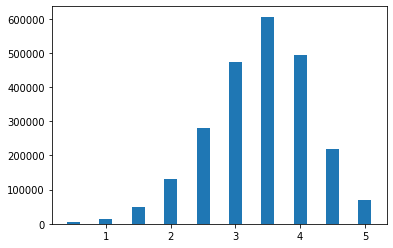

In [15]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Estimated Ratings using PMF

In [16]:
with open('../data/pmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

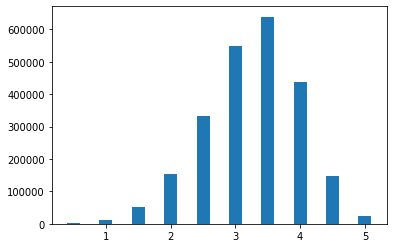

In [17]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

- The estimated ratings of BPMF are more spread out, having more weight on high rated movies.

Still, BPMF has a difference in the proportion of low and high ratings compared to the train and test data. This may have something to do with the assumed distribution that generates the ratings.

### Model: Poisson Matrix Factorization (PoiMF)

In PoiMF, a Poisson distribution is assumed to generate the ratings in the matrix. PoiMF has almost the same posterior distribution as the BPMF, except that the assumed distributions are Poisson and Gamma, with the hyperparameters corresponding to those distributions.

\begin{equation}
    p(R_{ij} | U_i, V_j, e_i, n_j) = Poisson(R_{ij}|U_i, V_j, e_i, n_j) 
\end{equation}

where 
\begin{equation}
    p(U_i| e_i) = Gamma(1, e_i) \\
    p(V_j| n_j) = Gamma(1, n_j) \\
    p(e_i) = Gamma(1,1) \\
    p(n_j) = Gamma(1,1)
\end{equation}

In [18]:
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        e_u = pyro.sample('e_u', dist.Gamma(1, 1))
        with pyro.plate('user_k', k):
            theta_u_k = pyro.sample('theta_u_k', dist.Gamma(1, e_u))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        n_i = pyro.sample('n_i', dist.Gamma(1, 1))
        with pyro.plate('movie_k', k):
            beta_i_k = pyro.sample('beta_i_k', dist.Gamma(1, n_i))
    with poutine.mask(mask=torch.tensor(is_observed)):
        pyro.sample("obs", dist.Poisson(torch.mm(
            theta_u_k.T, beta_i_k)), obs=data)

### Inference

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=1, warmup_steps=1)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples = mcmc.get_samples()

In [ ]:
# Run this when you do not have 'poissonmf_posterior_samples.pickle'
"""
#with open('../data/poissonmf_posterior_samples.pickle', 'wb') as handle:
    #pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
#rounded_estimate_ratings = util_pmf.calc_average_ratings(
posterior_samples['theta_u_k'], posterior_samples['beta_i_k'])
#with open('../data/poissonmf_rounded_posterior_samples.pickle',
'wb') as handle:
    #pickle.dump(rounded_estimate_ratings, handle,
    protocol=pickle.HIGHEST_PROTOCOL)
"""

In [19]:
with open('../data/poissonmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

### Criticism

We compare the distribution of estimated ratings using PoiMF, BPMF,and PMF.

#### Distribution of Estimated Ratings using PoiMF

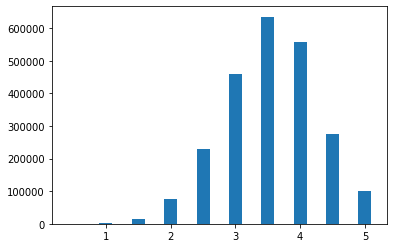

In [20]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Estimated Ratings using BPMF

In [21]:
with open('../data/bpmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

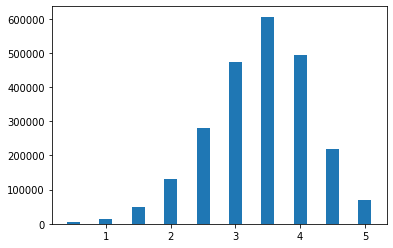

In [22]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

#### Distribution of Estimated Ratings using PMF

In [23]:
with open('../data/pmf_rounded_posterior_samples.pickle', 'rb') as f:
    rounded_estimate_ratings = pickle.load(f)

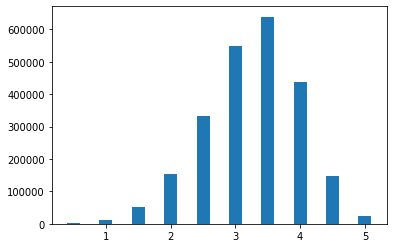

In [24]:
util_pmf.plot_rounded_estimates(rounded_estimate_ratings)

- The PoiMF has more high rating estimates compared to BPMF and PMF (closer to the mode of the ratings of the train data).
- PoiMF does not consider the lower ratings as much compared to BPMF and PMF.

### Criticism using POP-PC and PPC

We use the following simple discrepancies for the POP-PC and PPC for MFs.
- Mean, Median, First Quantile, and Third Quantile

In [30]:
Jayppc_mean, ppc_median, ppc_first_q, ppc_third_q, \
    poppc_mean, poppc_median, poppc_first_q, poppc_third_q \
    = util_pmf.model_assessment(train_ratings, test_ratings)

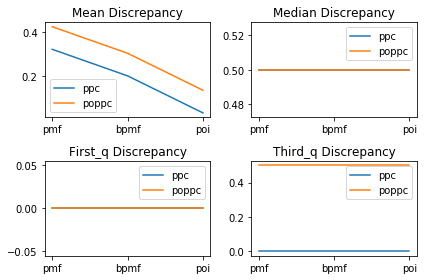

In [31]:
util_pmf.plot_poppc_ppc(ppc_mean, ppc_median,
                        ppc_first_q, ppc_third_q,
                        poppc_mean, poppc_median,
                        poppc_first_q, poppc_third_q)

## Gaussian Mixture Model for MovieLens dataset

__Overview:__ In this section, we will explore two different GMM models using different priors and inference methods; in attempt to cluster movies into different genres/release periods. We mainly focus on 5 features: revenue, budget, popularity, vote_count and vote average, using a subset of 1000 data points. Features are normalized by the mean and variance to standardize our hyperparameter values and avoid errors during numerical computation.

__Priors:__  We choose 5-10 cluster based on the fact that the top movie genres are: Comedy, Drama, Thriller, Action, Romance, Adventure, and we have release periods: 2010s, 2000s, 1990s, 1980s. 

In [50]:
movies_metadata_dir = os.path.join("data", "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)
movies_metadata[["revenue", "budget", "vote_count",
                 "vote_average", "popularity"]].head()

,revenue,budget,vote_count,vote_average,popularity
0,373554033.0,30000000,5415.0,7.7,21.946943
1,262797249.0,65000000,2413.0,6.9,17.015539
2,81452156.0,16000000,34.0,6.1,3.859495
3,187436818.0,60000000,1886.0,7.7,17.924927
4,64350171.0,35000000,174.0,5.5,5.231580


### Experiment 1 (SVI and Normal Inverse-Gamma Prior):

### Model

Consider a standard GMM model. Given $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define our priors $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    \pi \sim Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$, and for each $\mu_k \in \mathbb{R}^D$:
\begin{equation}
    \mu_k \sim Normal(\mu_k | 0, I)
\end{equation}

and for each component $\sigma_k^2 \in \mathbb{R}^D$:
\begin{equation}
    \sigma_k^2 \sim InvGamma(\sigma_k^2 | 1, 1)
\end{equation}

In [51]:
data, data_new = util_gmm.get_train_test_split(movies_metadata)
K = 8  # Clusters
d = len(data[0])  # Dimensions
N = len(data)  # Length of data

In [52]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(
            locs[assignment], scale_), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'scale']))

### Inference

Here, we run SVI and compute the MAP estimates of the posterior for $p(\pi, \mu, \sigma^2|x_n)$.

In [53]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [54]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss


loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

seed = 87, init loss = 4406.3232421875


In [55]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(
        lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

In [56]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

### Criticism:

The ELBO seems to decrease in general but increases midway. The gradients of the scale, locs and weights are noisy.

__Issues:__ The priors collapses to a local minimum during SVI, and we see that all clusters tend to converge to the same point. Furthermore, the Inverse Gamma prior for the variance does not capture cross-covariances between features, i.e. the GMM is not fully probabilistic.

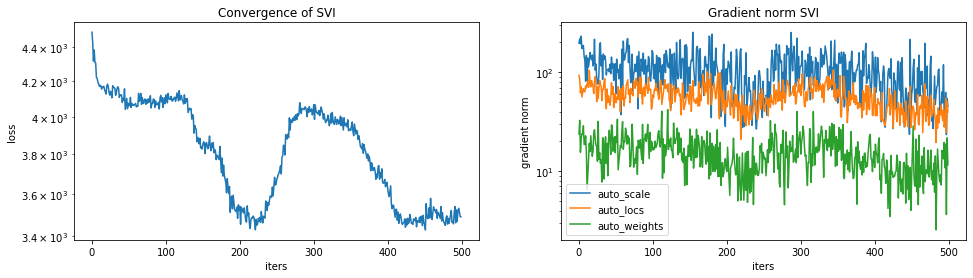

In [57]:
util_gmm.plot_svi_convergence(losses, gradient_norms)

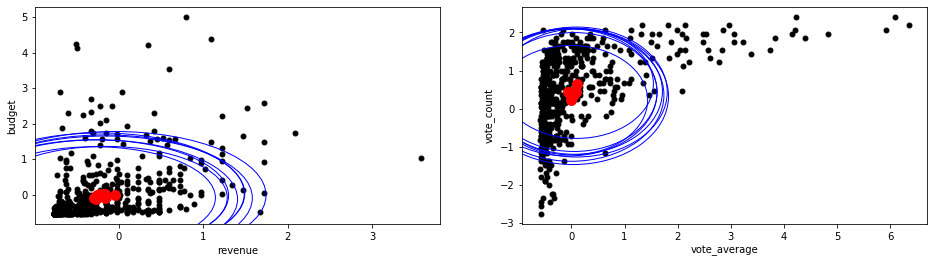

In [58]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121, xlabel="revenue", ylabel="budget")
util_gmm.plot(data[:, 0:2], locs[:, 0:2], scale, K=K, d=d, ax=ax)
ax = fig.add_subplot(122, xlabel="vote_average", ylabel="vote_count")
util_gmm.plot(data[:, 2:4], locs[:, 2:4], scale, K=K, d=d, ax=ax)

__Alternative:__ Consider MCMC for full posterior over components. For multivariate covariance matrix, a conjugate prior is the Inverse-Wishart distribution [Gelmen et al., 2003]. However, the Inverse Wishart is not a suitable prior. Firstly, positive-definite and symmetric constraints of the probability of generating valid samples is low using the Wishart. Secondly, the Wishart distribution is heavy-tailed; which are obstructions to ergodicity which is requirement for MCMC. When tails are heavy, samplers may drift around which can be difficult to return back to heavy mass, i.e. high computational costs.

__Solution:__ Try the LKJCorr Prior for full probabilistic covariance [Barnard, McCulloch & Meng, 2000]. The LKFCorr distribution has lighter tails which pairs better with MCMC. This uses the Cholesky factorization for faster computation, $\Sigma= L L^T$


### Experiment 2 (NUTS and Normal LKJ Correlation Cholesky Prior):

### Model
Given the same setup as before:
\begin{align}
    \pi &\sim Dir(\pi | \alpha \mathbb{1}_K) \\
    \mu_k &\sim Normal(\mu_k | 0, I)
\end{align}

Define the covariance matrix as:
\begin{equation}
    \Sigma = diag(\theta) \Omega diag(\theta) \iff \Omega_{i,j} = \Sigma_{i,j} (\theta_i \theta_j)^{-1}
\end{equation}

Set priors where $\theta_k$ is the scale vector and $\Omega$ is the correlation matrix defined by
\begin{align}
    \theta_k &\sim HalfCauchy(1) \\
    \Omega_k &\sim LKJCorr(\eta) \\
\end{align}

The LKJ correlation distribution is defined by
\begin{equation}
    LKJCorr(\Sigma | \eta) \propto det(\Sigma)^{\eta -1}
\end{equation}

In [59]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    theta = pyro.sample("theta", dist.HalfCauchy(1*torch.ones(d)).to_event(1))
    eta = torch.ones(1)
    L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(d, eta))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    with pyro.plate('components', K):
        mu = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), 1*torch.eye(d)))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(
            mu[assignment], scale_tril=L_Omega), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'L_omega']))

### Inference

__Steps:__ Run NUTS MCMC over 250 samples, draw the trace plots of the posterior samples and compute the Bayes estimate of $p(\pi, \mu, \Sigma|x_n)$.

In [60]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 300/300 [04:07,  1.21it/s, step size=3.88e-02, acc. prob=0.854]


In [61]:
Sigma_samples = util_gmm.get_Sigma_samples(posterior_samples)
cov = util_gmm.get_bayes_estimate_cov(Sigma_samples, K)
mu = util_gmm.get_bayes_estimate_mu(posterior_samples)
pi = util_gmm.get_bayes_estimate_pi(posterior_samples)

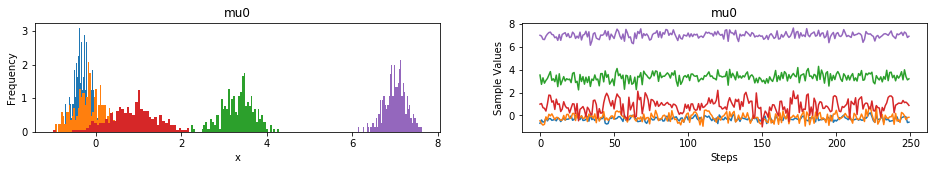

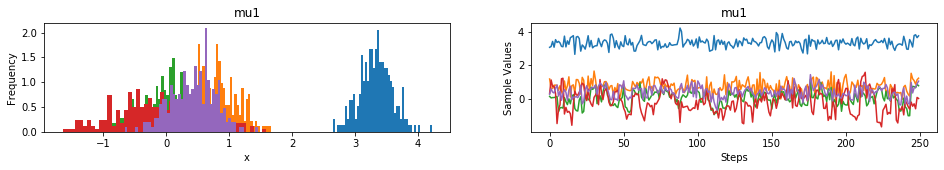

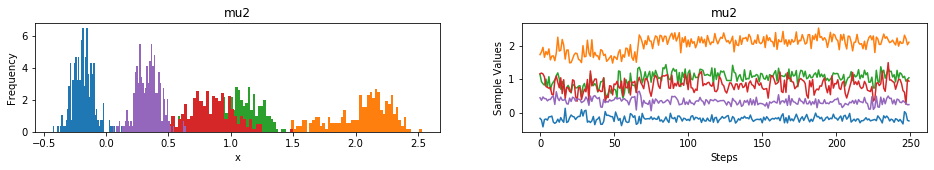

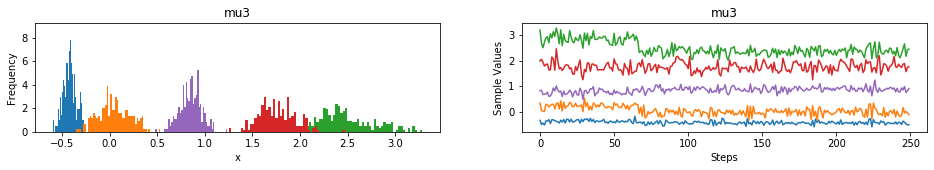

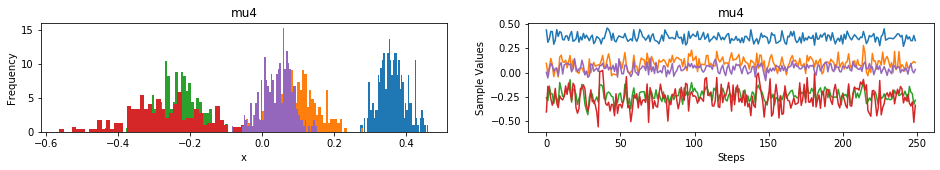

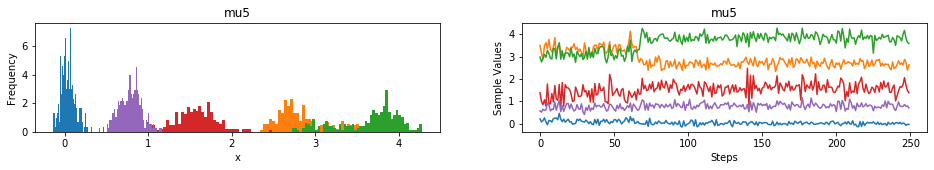

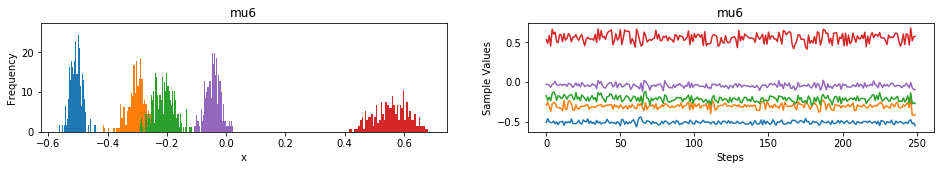

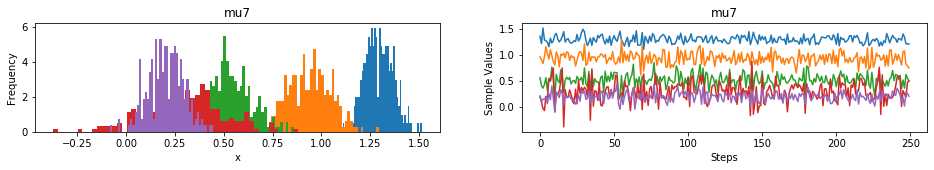

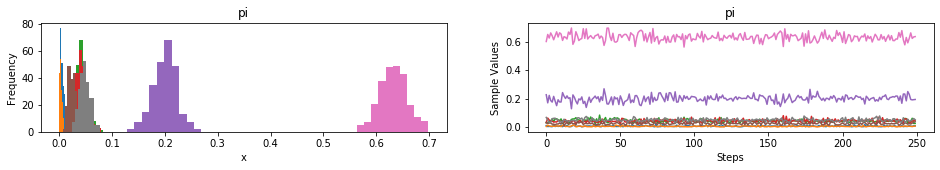

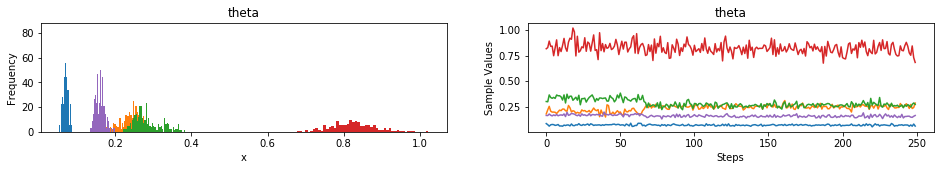

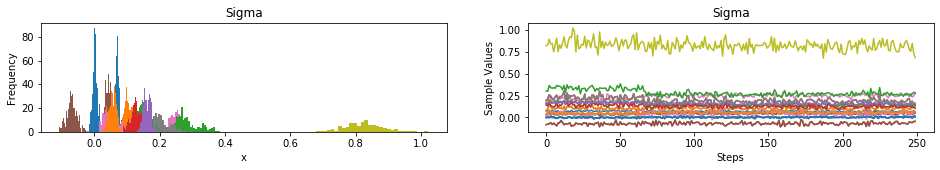

In [62]:
util_gmm.plot_mcmc_mu(posterior_samples, K, d)
util_gmm.plot_mcmc_pi(posterior_samples, K, d)
util_gmm.plot_mcmc_theta(posterior_samples, K, d)
util_gmm.plot_mcmc_Sigma(Sigma_samples, K, d)

### Criticism

__Results:__ After looking at the assignments of each movie using the trained GMM, we found that there is no significant pattern in genres/release periods, i.e. this is an issue of *non-identifiability*. However, the components of $\mu_k, \Sigma_k$ seem to capture the general distribution/shape of the data well looking at the trace plots. Most of the density in the GMM is clustered within a single component. 



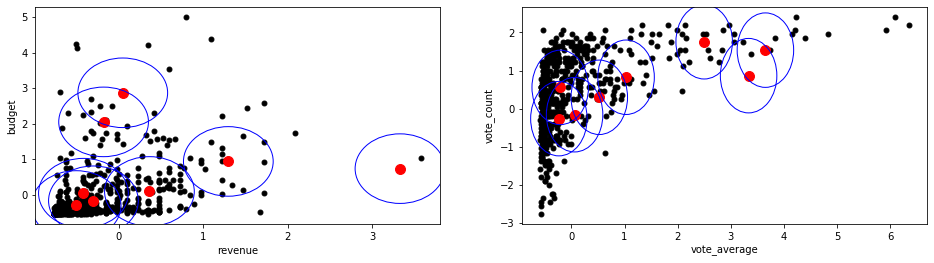

In [71]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121, xlabel="revenue", ylabel="budget")
util_gmm.plot(data[:, 0:2], mu[:, 0:2], cov, K=K, d=d, ax=ax)
ax = fig.add_subplot(122, xlabel="vote_average", ylabel="vote_count")
util_gmm.plot(data[:, 2:4], mu[:, 2:4], cov, K=K, d=d, ax=ax)

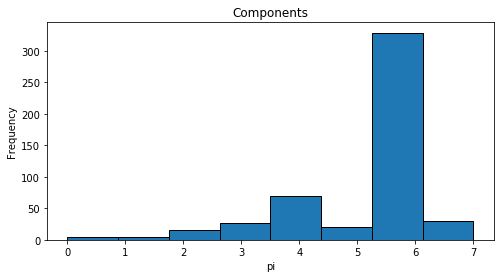

In [72]:
predictive = Predictive(model, posterior_samples)
assignment = predictive.get_samples(data)["assignment"][-1, :]
plt.figure(figsize=(8, 4))
plt.hist(assignment, bins=K, ec="k")
plt.xlabel("pi")
plt.ylabel("Frequency")
plt.title("Components")
plt.show()

### Posterior Predictive Checks

Recall that A PPC is defined by:
\begin{equation}
    PPC(x^{obs}; g, d) = E[g(d(x^{rep}, \theta), d(x^{obs}, \theta)) | x^{obs}]
\end{equation}


A realized discrepancy $d(x, \theta)$ is a function of both data and hidden variables [Ranganath & Blei, 2019]. One realized discrepancy is the log-likelihood for GMMs:
\begin{align}
    d(x, \theta) 
    &= \sum_{i=1}^{n} \log p(x_i | \theta) \\
    &= \sum_{i=i}^{n} \log \Big[ \sum_{k=1}^{K} \pi_k N(x_i; \mu_k, \Sigma_k) \Big]
\end{align}

In [70]:
# Compute replicated samples from posterior predictive
data_rep = []
for i in range(N):
    cluster = pyro.sample('category', dist.Categorical(torch.tensor(pi)))
    idx = cluster.item()
    sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    while sample[0] < min(data[:, 0]) or sample[1] < min(data[:, 1]):
        # Only sample valid points
        sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    data_rep.append(sample.tolist())
data_rep = torch.tensor(data_rep)

In [66]:
d_obs = util_gmm.compute_log_likelihood(data, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)

ppc = np.sqrt((d_obs - d_rep)**2)
print('Discrepancy of observed data: {}'.format(d_obs))
print('Discrepancy of replicated data: {}'.format(d_rep))
print('Posterior Predictive Check: {}'.format(ppc))

Discrepancy of observed data: -193525.6875
Discrepancy of replicated data: -190098.4375
Posterior Predictive Check: 3427.25


### Population Predictive Checks

Recall that a POP-PC is defined by:
\begin{equation}
    POP-PC(x^{obs}, F; g, d) = E[g(d(x^{rep}, \theta), d(x^{new}, \theta)) | x^{obs}, F]
\end{equation}

In [73]:
d_new = util_gmm.compute_log_likelihood(data_new, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)

pop_pc = np.sqrt((d_new - d_rep)**2)
print('Discrepancy of new data: {}'.format(d_new))
print('Discrepancy of replicated data: {}'.format(d_rep))
print('Population Predictive Check: {}'.format(pop_pc))

Discrepancy of new data: -192572.578125
Discrepancy of replicated data: -190805.0625
Population Predictive Check: 1767.515625


### Hallucinated Data Simulation

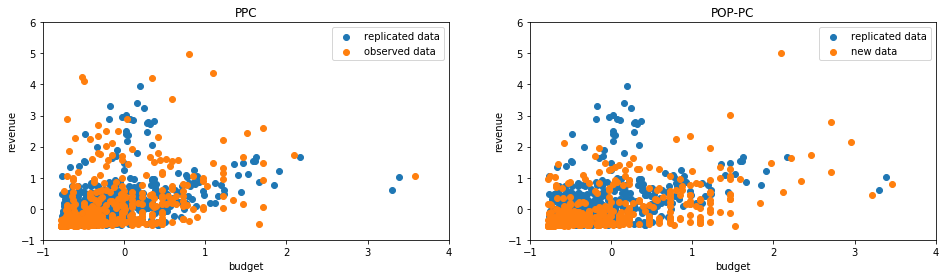

In [75]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(
    121, xlabel="budget", ylabel="revenue",
    title="PPC", ylim=(-1, 6), xlim=(-1, 4))
ax1.scatter(data_rep[:, 0], data_rep[:, 1], label="replicated data")
ax1.scatter(data[:, 0], data[:, 1], label="observed data")
ax1.legend()
ax2 = fig.add_subplot(
    122, xlabel="budget", ylabel="revenue",
    title="POP-PC", ylim=(-1, 6), xlim=(-1, 4))
ax2.scatter(data_rep[:, 0], data_rep[:, 1], label="replicated data")
ax2.scatter(data_new[:, 0], data_new[:, 1], label="new data")
ax2.legend()
fig.show()

### Choosing number of clusters K based on PPC and POP-PC 

The data below is collected from repeating the experiements above and changing the value of K to observe how PPCs/POP-PCs respond.

__Findings:__ In general, POP-PCs are higher than PPCs which is an expected result since we are evaluating the replicated data against new/unseen data. We observe that as $K$ increases from 10 onwards, the discrepancy of POP-PCs increases while PPCs do not increase as much; and the PPC/POP-PC scores are lowest between 6 to 10. Interestingly enough, there is a *Zig-Zag* pattern such that *even* numbers of clusters tend to have lower scores; and *odd* clusters tend to have higher scores. This suggests that the optimal number of clusters is either 6, 8 or 10.

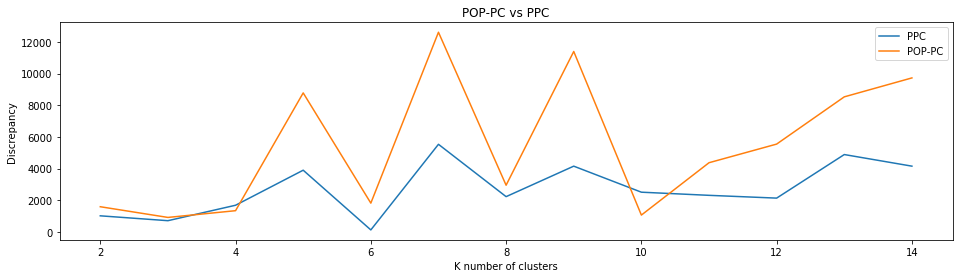

In [76]:
K_variable = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
ppc_response = [1028425, 499302, 2828440, 15175103, 15331, 30597838,
                4952241, 17231320, 6284324, 5327910, 4547856, 23852158,
                17231514]

pop_pc_response = [2522314, 833008, 1790494, 77044920, 3299700,
                   158990000, 8688746, 129820000, 1125285, 19079732,
                   30745118, 72734376, 94568328]

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(
    111, xlabel="K number of clusters", ylabel="Discrepancy", title="POP-PC vs PPC")
ax.plot(K_variable, np.sqrt(ppc_response), label="PPC")
ax.plot(K_variable, np.sqrt(pop_pc_response), label="POP-PC")
ax.legend()
fig.show()

### Conclusions
* Non-identifiability of clusters is a challenge for clustering movies.
* LKJCorr prior captures full probabilistic covariance.
* Combining POP-PCs and PPCs to choose number of clusters.

### References

- Population Predictive Checks https://arxiv.org/abs/1908.00882
- MovieLens Dataset https://www.kaggle.com/rounakbanik/the-movies-dataset
- Probabilistic Matrix Factorization https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf
- Bayesian Probabilistic Matrix Factorization using Markov Chain Monte Carlo https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf
- Scalable Recommendation with Poisson Factorization https://arxiv.org/pdf/1311.1704.pdf
- NUTS http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf